In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from deap import algorithms, base, creator, tools
import numpy as np

from rdkit.Chem import PandasTools

from rdkit.Chem import rdMolDescriptors

import random
from scoop import futures

In [2]:
new_data = {'IDNUMBER': ['NECA', 'BnoCPA', 'CHEMBL477444', 'TRABODENOSON', 'CHEMBL3414936'],
            'canonical_smiles': ['NC1=C(N=CN2[C@@H]3O[C@H](C(NCC)=O)[C@@H](O)[C@H]3O)C2=NC=N1', 'OC[C@H]([C@@H](O)[C@H]1O)O[C@H]1N2C=NC3=C(N[C@@H]4CCC[C@H]4OCC5=CC=CC=C5)N=CN=C32', 'O[C@@H]1[C@H](O)[C@@H](CCl)O[C@H]1n1cnc2c(NC3CCCC3)ncnc21', 'O=[N+]([O-])OC[C@H]1O[C@@H](n2cnc3c(NC4CCCC4)ncnc32)[C@H](O)[C@@H]1O', 'CCn1nnc([C@H]2O[C@@H](n3cnc4c(N)ncnc43)[C@H](O)[C@@H]2O)n1'],
           'pKi' : [6.61, 6.18, 9.23, 9.01, 9.04],
           }
new_rows = pd.DataFrame(new_data)

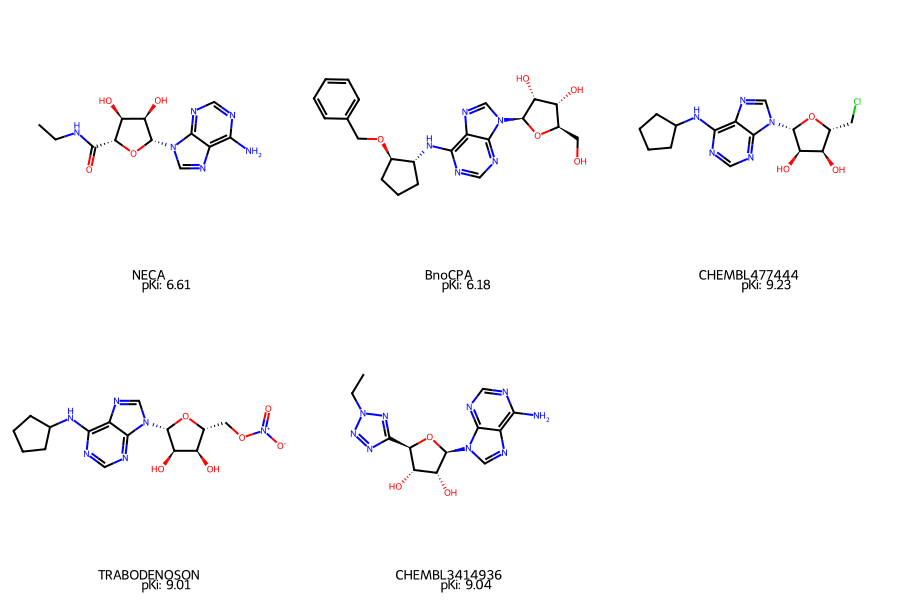

In [22]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem import PandasTools

def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol

# Add a new column 'Molecule' to DataFrame with RDKit Mol objects
new_rows['Molecule'] = new_rows['canonical_smiles'].apply(smiles_to_mol)

# Generate 2D coordinates for better depiction
new_rows['Molecule'].apply(rdDepictor.Compute2DCoords)

# Create a grid
img = Draw.MolsToGridImage(list(new_rows['Molecule']), molsPerRow=3, subImgSize=(300, 300), useSVG = True,
                            legends=[f"{id} \n       pKi: {pKi:.2f}" if id is not None else "" for id, pKi in zip(new_rows_with_blank['IDNUMBER'], new_rows_with_blank['pKi'])])

# Save or display the grid
# img.save("molecule_grid.png")  # Save the grid as an image
img

In [3]:
PandasTools.AddMoleculeColumnToFrame(new_rows,'canonical_smiles','ROMol')

In [4]:
chemdiv = pd.read_csv('../compound_data/zinc_drugs/zinc_without_pain_preds.csv')

In [5]:
chemdiv.shape

(10316950, 12)

In [6]:
chemdiv = chemdiv[chemdiv['predictions'] > 7.0]

In [7]:
chemdiv.shape

(218098, 12)

In [8]:
PandasTools.AddMoleculeColumnToFrame(chemdiv,'smiles','ROMol')

In [9]:
chemdiv['fp'] = chemdiv['ROMol'].apply(lambda x: rdMolDescriptors.GetMorganFingerprint(x, 2))

In [10]:
new_rows['fp'] = new_rows['ROMol'].apply(lambda x: rdMolDescriptors.GetMorganFingerprint(x, 2))

In [11]:
new_rows.rename(columns={'IDNUMBER': 'zinc_id', 'pKi' : 'predictions'}, inplace = True)

In [12]:
new_rows = new_rows[['zinc_id', 'ROMol', 'fp', 'predictions']]

In [13]:
chemdiv = chemdiv[['zinc_id', 'ROMol', 'fp', 'predictions']]

In [14]:
S_full = chemdiv
S_prior = new_rows

In [15]:
# Calculate coverage score
def calculate_coverage_score(subset, S_full, S_prior):
    subset_indices = list(subset)
    subset_df = S_full.iloc[subset_indices]

    if isinstance(S_prior, pd.DataFrame):
        subset = pd.concat([subset_df, S_prior])
    elif S_prior == 0:
        subset = subset_df
    else:
        print('hehe')
    fp_counts_subset = get_fp_counts(subset)

    # Calculate base and final coverage scores 
    base_scores = get_base_coverage_scores(fp_counts_subset, fp_counts_full, len(subset), len(actual_s_full))
    final_scores = get_final_coverage_scores(base_scores, fp_counts_subset, len(subset))

    compound_scores = []

    for index, row in subset.iterrows():
        curr_score = []
        for onbit in row['fp'].GetNonzeroElements().keys():
            try:
                idx = final_scores[list(fp_counts_subset.keys()).index(onbit)]
                curr_score.append(idx)
            except:
                pass
            
        summed_compound_score = sum(curr_score)
        
        compound_scores.append(summed_compound_score)
        
    subset_score = sum(compound_scores)

    
    return subset_score, subset.predictions.mean()

# Get fingerprint counts
def get_fp_counts(dataframe):
    fp_counts = {}
    for index, row in dataframe.iterrows():
        for onbit in row['fp'].GetNonzeroElements().keys():
            fp_counts[onbit] = fp_counts.get(onbit, 0) + 1
    return fp_counts
                
# Calculate base coverage score
def get_base_coverage_scores(fp_counts_subset, fp_counts_full, N_subset, N_full):
    
    alpha = 1
    P_sampled = N_subset / N_full
    
    base_scores = []
    for fp, count in fp_counts_subset.items():
        if fp_counts_full[fp] == N_full:
            continue
        P_smooth = (count + alpha) / (fp_counts_full[fp] + alpha/P_sampled) 
        base_scores.append(-np.log(P_smooth/P_sampled))
        
    return base_scores

# Calculate final coverage score 
def get_final_coverage_scores(base_scores, fp_counts_subset, N_subset):

    final_scores = []
    for i, score in enumerate(base_scores):
        count = list(fp_counts_subset.values())[i]
        
        p1 = count/N_subset
        p2 = 1 - p1

        if count == N_subset:
            H = 0
        else:
            H = -(p1*np.log(p1) + p2*np.log(p2)) / np.log(2)
        
        if score < 0 and count/N_subset > 0.5:
            final_scores.append(score*(2 - H))

        else:
            final_scores.append(score*H)
            
    return final_scores

In [16]:
actual_s_full = pd.concat([S_full, S_prior])
fp_counts_full = get_fp_counts(actual_s_full) 

In [17]:
creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0, ))  
creator.create("Individual", list, fitness=creator.FitnessMax)

In [18]:
def initIndividual(content, MU):
    return creator.Individual([random.randint(0, content - 1) for _ in range(MU)])

def mate(ind1, ind2):
    common_indices = set(ind1) & set(ind2)
    uncommon_ind1 = [x for x in ind1 if x not in common_indices]
    uncommon_ind2 = [x for x in ind2 if x not in common_indices]

    for i in range(len(uncommon_ind1)):
        ind1[ind1.index(uncommon_ind1[i])] = uncommon_ind2[i]
        ind2[ind2.index(uncommon_ind2[i])] = uncommon_ind1[i]

    return ind1, ind2
    
def mutate(ind):
    for i in range(len(ind)):
        unused_indices = [x for x in range(len(S_full)) if x not in ind]
        if unused_indices:
            index_to_swap = random.choice(unused_indices)
            ind[i] = index_to_swap
    return ind,

def evaluate(individual):
    # Calculate coverage score
    coverage_score, pki = calculate_coverage_score(individual, S_full, S_prior) 
    print(coverage_score, pki)
    return coverage_score, pki,

In [19]:
MU = 40

In [20]:
toolbox = base.Toolbox()
toolbox.register("individual", initIndividual, content=len(S_full), MU = MU)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", mate)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", evaluate)
toolbox.register("map",futures.map)

In [21]:
pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)

In [22]:
algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=MU, cxpb=0.2, mutpb=0.1, ngen=10000, stats=stats, halloffame=hof)

/Users/syedzayyanmasud/anaconda3/envs/mphil/lib/python3.10/site-packages/scoop/fallbacks.py:38: RuntimeWarning: SCOOP was not started properly.
Be sure to start your program with the '-m scoop' parameter. You can find further information in the documentation.
Your map call has been replaced by the builtin serial Python map().
  warnings.warn(


-290.3763380407641 7.310975009423487
-200.64590213938942 7.358775087098946
-287.0417918652433 7.417219156109905
-278.631344851776 7.38309591876346
-268.3973852857415 7.365658430578722
-239.54444635834827 7.366136492683122
-240.1570872478251 7.370756648418236
-306.9359972318242 7.378669763783743
-253.2761367910189 7.343136153327927
-295.91315901514366 7.409787489850939
-229.98458003361552 7.318443116201052
-274.43899227555187 7.38315916343718
-218.86317228735308 7.2850642876818
-240.85693077324336 7.33415325008708
-251.47704338987006 7.347981161645251
-275.0475660573379 7.40699844575026
-287.9545642206715 7.284831263424058
-282.0270893381157 7.309526200413403
-185.972468368167 7.298688959725188
-313.60229037698207 7.369076756222365
-253.0022720698281 7.3716142233509725
-192.66493986766037 7.302206468686733
-240.27670482030237 7.3505841939801355
-190.57644841421043 7.2858836286220265
-198.02359064698712 7.441534210065442
-236.34716776631484 7.347234299266054
-174.49448598903209 7.3657220

KeyboardInterrupt: 

In [ ]:
optimal_subset = hof[0]

subset_smiles = [S_full['smiles'][i] for i in optimal_subset]
print('Optimal subset molecules:', subset_smiles)

https://greglandrum.github.io/rdkit-blog/posts/2022-01-04-number-of-unique-fp-bits.html

In [ ]:
display(chemdiv.iloc[optimal_subset]['ROMol'].values[0])

In [ ]:
display(chemdiv.iloc[optimal_subset]['ROMol'].values[1])

In [ ]:
optimal_comps = chemdiv.iloc[optimal_subset]

In [ ]:
optimal_comps.to_csv('../compound_data/zinc_drugs/subset_40.csv')